In [1]:
## Import all the necessary libraries 

import warnings
warnings.filterwarnings('ignore') # ignore any warnings 

# import all data utilities 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN 

# import all the various classifier models 
#import xgboost

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
def setplotParams():
    # Set the plot params

    plt.rcParams["figure.figsize"] = [9, 5]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.labelsize"] = 6
    plt.rcParams["axes.titlesize"] = 6
    plt.rcParams["axes.titlepad"] = 8
    plt.rcParams["axes.facecolor"] = "white"
    plt.rcParams["axes.linewidth"] = 0.3
    plt.rcParams["axes.grid"] = True
    plt.rcParams["grid.color"] = "green"
    plt.rcParams["grid.linestyle"] = "--"
    plt.rcParams["grid.linewidth"] = 0.2
    plt.rcParams["xtick.labelsize"] = 6
    plt.rcParams["ytick.labelsize"] = 6
    plt.rcParams["legend.fontsize"] = 7
    plt.rcParams["legend.labelspacing"] = 1
    plt.rcParams["lines.linewidth"] = 0.7
    

In [3]:
def get_transformed_data(sub_df):
    # USed formalware_datection dataset
    sub_df.drop_duplicates(keep=False)
    sub_df['Label'] = sub_df['Label'].map({'non-malicious': 1, 'malicious': 0})
    
    return sub_df

In [4]:
## Path for anomaly dataset
#real_filepath = '../Real Datasets/Anomaly Detection/Participants_Data_WH18/anomaly.csv'
#ctgan_filepath = '../Synthetic Datasets/sdv_ctgan/sdv_ctgan_anomaly_200.csv'
#tvae_filepath = '../Synthetic Datasets/sdv_tvae/sdv_tvae_anomaly_200.csv'

## Path for malware detection dataset
real_filepath = '../Real Datasets/Malware Detection/malware_detection.csv'
ctgan_filepath = '../Synthetic Datasets/sdv_ctgan/sdv_ctgan_malware_detection_200.csv'
tvae_filepath = '../Synthetic Datasets/sdv_tvae/sdv_tvae_malware_detection_200.csv'

real_df = pd.read_csv(real_filepath)
real_df = get_transformed_data(real_df)
ctgan_df = pd.read_csv(ctgan_filepath)
ctgan_df.drop('Unnamed: 0', inplace=True, axis = 1)
ctgan_df = get_transformed_data(ctgan_df)
tvae_df = pd.read_csv(tvae_filepath)
tvae_df.drop('Unnamed: 0', inplace=True, axis = 1)
tvae_df = get_transformed_data(tvae_df)

#smt = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=None)
#smt = BorderlineSMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5, n_jobs=None, kind='borderline-1')
smt = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5, n_jobs=None)


In [5]:
y = real_df['Label']
X = real_df.drop('Label', axis=1)

X_smt, y_smt = smt.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size = 0.3)

In [6]:
y_ctgan = ctgan_df['Label']
X_ctgan = ctgan_df.drop('Label', axis=1)

X_gan_smt, y_gan_smt = smt.fit_resample(X_ctgan, y_ctgan)
X_train_gan, X_test_gan, y_train_gan, y_test_gan = train_test_split(X_gan_smt, y_gan_smt, test_size = 0.3)


In [7]:
y_tvae = tvae_df['Label']
X_tvae = tvae_df.drop('Label', axis=1)

X_vae_smt, y_vae_smt = smt.fit_resample(X_tvae, y_tvae)
X_train_vae, X_test_vae, y_train_vae, y_test_vae = train_test_split(X_vae_smt, y_vae_smt, test_size = 0.3)


In [8]:
dt_class_real = DecisionTreeClassifier(max_depth = 40, 
                                  random_state=42, 
                                  max_leaf_nodes=15, 
                                  class_weight='balanced')

dt_class_real.fit(X_train, y_train)
result_train = dt_class_real.score(X_train,y_train)
print(" The Score of the trained model of real dataset is -- : {:.2f}".format(result_train))

y_predict = dt_class_real.predict(X_test)
result_test = dt_class_real.score(X_test, y_test)
print(" The Prediction Score of real dataset is -- : {:.4f}".format(result_test))


print("The Classification Reoprt of real dataset is :")
print(classification_report(y_test, y_predict))

y_prob = dt_class_real.predict_proba(X_test)[:, -1]
fpr, tpr, t = roc_curve(y_test, y_prob)
dtp, dtr, t = precision_recall_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


#----------------classifier for gan --------------------------------------------------------------------------------------------

dt_class_ctgan = DecisionTreeClassifier(max_depth = 40, 
                                  random_state=42, 
                                  max_leaf_nodes=15, 
                                  class_weight='balanced')

dt_class_ctgan.fit(X_train_gan, y_train_gan)
result_train_gan = dt_class_ctgan.score(X_train_gan,y_train_gan)
print(" The Score of the trained model of gan dataset is -- : {:.2f}".format(result_train_gan))

y_predict_gan = dt_class_ctgan.predict(X_test_gan)
result_test_gan = dt_class_ctgan.score(X_test_gan, y_test_gan)
print(" The Prediction Score of gan dataset is -- : {:.4f}".format(result_test_gan))


print("The Classification Reoprt of gan dataset is :")
print(classification_report(y_test_gan, y_predict_gan))

y_prob_gan = dt_class_ctgan.predict_proba(X_test_gan)[:, -1]
fpr_gan, tpr_gan, t = roc_curve(y_test_gan, y_prob_gan)
dtp_gan, dtr_gan, t = precision_recall_curve(y_test_gan, y_prob_gan)
roc_auc_gan = auc(fpr_gan, tpr_gan)

#-----------------------classifier for vae-------------------------------------------------------------------------------------
dt_class_vae = DecisionTreeClassifier(max_depth = 40, 
                                  random_state=42, 
                                  max_leaf_nodes=15, 
                                  class_weight='balanced')

dt_class_vae.fit(X_train_vae, y_train_vae)
result_train_vae = dt_class_vae.score(X_train_vae, y_train_vae)
print(" The Score of the trained model of vae dataset is -- : {:.2f}".format(result_train_vae))

y_predict_vae = dt_class_vae.predict(X_test_vae)
result_test_vae = dt_class_vae.score(X_test_vae, y_test_vae)
print(" The Prediction Score of vae dataset is -- : {:.4f}".format(result_test_vae))


print("The Classification Reoprt of vae dataset is :")
print(classification_report(y_test_vae, y_predict_vae))

y_prob_vae = dt_class_vae.predict_proba(X_test_vae)[:, -1]
fpr_vae, tpr_vae, t = roc_curve(y_test_vae, y_prob_vae)
dtp_vae, dtr_vae, t = precision_recall_curve(y_test_vae, y_prob_vae)
roc_auc_vae = auc(fpr_vae, tpr_vae)


 The Score of the trained model of real dataset is -- : 1.00
 The Prediction Score of real dataset is -- : 0.9779
The Classification Reoprt of real dataset is :
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       101
           1       0.95      1.00      0.98        80

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181

 The Score of the trained model of gan dataset is -- : 0.87
 The Prediction Score of gan dataset is -- : 0.7333
The Classification Reoprt of gan dataset is :
              precision    recall  f1-score   support

           0       0.74      0.82      0.77        92
           1       0.73      0.63      0.68        73

    accuracy                           0.73       165
   macro avg       0.73      0.72      0.72       165
weighted avg       0.73      0.73      0.73       165

 The Score of the trained m

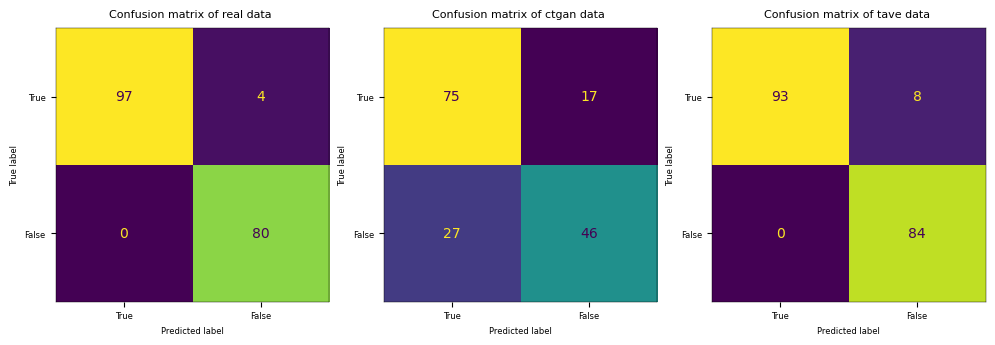

In [9]:
plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["axes.grid"] = False
#plt.rcParams["figure.autolayout"] = True
#plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["axes.titlesize"] = 8
plt.rcParams["axes.titlepad"] = 8
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.linewidth"] = 0.3
#plt.rcParams["grid.color"] = "green"
#plt.rcParams["grid.linestyle"] = "--"
#plt.rcParams["grid.linewidth"] = 0.2
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6
plt.rcParams["legend.fontsize"] = 6
plt.rcParams["legend.labelspacing"] = 1
plt.rcParams["lines.linewidth"] = 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title("Confusion matrix of real data ")
ax2.set_title("Confusion matrix of ctgan data ")
ax3.set_title("Confusion matrix of tave data ")

realcf_matrix = confusion_matrix(y_test, y_predict)
realcf_display = ConfusionMatrixDisplay(realcf_matrix, display_labels = [True, False])

gancf_matrix = confusion_matrix(y_test_gan, y_predict_gan)
gancf_display = ConfusionMatrixDisplay(gancf_matrix, display_labels = [True, False])


vaecf_matrix = confusion_matrix(y_test_vae, y_predict_vae)
vaecf_display = ConfusionMatrixDisplay(vaecf_matrix, display_labels = [True, False])

realcf_display.plot(ax=ax1, colorbar=False)
gancf_display.plot(ax=ax2, colorbar=False)
vaecf_display.plot(ax=ax3, colorbar=False)
plt.show()

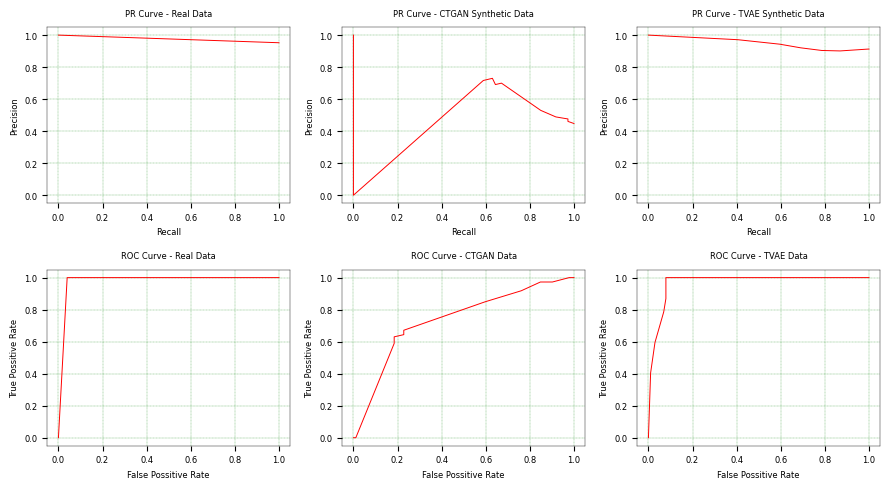

In [10]:
setplotParams()
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)

ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve - Real Data')
ax1.plot(dtr,dtp, c='red',label='dt')


ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curve - CTGAN Synthetic Data')
ax2.plot(dtr_gan,dtp_gan,c='red',label='dt')
      
ax3.set_xlim([-0.05,1.05])
ax3.set_ylim([-0.05,1.05])
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('PR Curve - TVAE Synthetic Data')
ax3.plot(dtr_vae,dtp_vae,c='red',label='dt')

ax4.set_xlim([-0.05,1.05])
ax4.set_ylim([-0.05,1.05])
ax4.set_xlabel('False Possitive Rate')
ax4.set_ylabel('True Possitive Rate')
ax4.set_title('ROC Curve - Real Data')
ax4.plot(fpr,tpr,c='red',label='dt')

ax5.set_xlim([-0.05,1.05])
ax5.set_ylim([-0.05,1.05])
ax5.set_xlabel('False Possitive Rate')
ax5.set_ylabel('True Possitive Rate')
ax5.set_title('ROC Curve - CTGAN Data')
ax5.plot(fpr_gan,tpr_gan,c='red',label='dt')

ax6.set_xlim([-0.05,1.05])
ax6.set_ylim([-0.05,1.05])
ax6.set_xlabel('False Possitive Rate')
ax6.set_ylabel('True Possitive Rate')
ax6.set_title('ROC Curve - TVAE Data')
ax6.plot(fpr_vae,tpr_vae,c='red',label='dt')

plt.savefig('../Ouput Files/Malware and Anomaly/compare_malware.png')